In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
!python -m spacy download en_core_web_lg
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
import string
nltk.download('punkt')
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

2022-10-13 16:16:52.863130: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 8.8 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
from sklearn.svm import OneClassSVM
one_svm = OneClassSVM()


In [ ]:
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))


['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
wv = api.load('word2vec-google-news-300')
wv.save('/content/drive/MyDrive/enterpret/vectors.kv')
wv = KeyedVectors.load('/content/drive/MyDrive/enterpret/vectors.kv')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/enterpret/train - train.csv')
eval = pd.read_csv('/content/drive/MyDrive/enterpret/evaluation - evaluation.csv')

In [ ]:
train.head()

,text,reason,label
0,this is an amazing app for online classes!but,good app for conducting online classes,1
1,very practical and easy to use,app is user-friendly,1
2,this app is very good for video conferencing.,good for video conferencing,1
3,i can not download this zoom app,unable to download zoom app,1
4,i am not able to download this app,want to download the app,1


In [ ]:
eval.head()

,text,reason,label
0,the app is crashing when i play a vedio,app crashes during playback,1
1,but i want to connect it to the tv from one de...,want compatibility with more smart televisions,0
2,very helpful when and home working remotley,good app for work,0
3,this zoom so called and missed call and mobile...,receiving incorrect phone number message,0
4,one of my favorite apps,good for spending time,0


In [ ]:
train.isnull().sum()

text      0
reason    0
label     0
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2061 entries, 0 to 2060
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2061 non-null   object
 1   reason  2061 non-null   object
 2   label   2061 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 48.4+ KB


In [ ]:
train.text.nunique()

2059

In [ ]:
train.reason.nunique()

2061

In [ ]:
train.label.value_counts()

1    2061
Name: label, dtype: int64

In [ ]:
eval.label.value_counts()

0    5999
1    3001
Name: label, dtype: int64

In [ ]:
###### Training Data ##########
train['text_len_before_cleaning'] = train.text.apply(lambda x : len(x))
train['reason_len_before_cleaning'] = train.reason.apply(lambda x : len(x))

##### Eval Data ################
eval['text_len_before_cleaning'] = eval.text.apply(lambda x : len(x))
eval['reason_len_before_cleaning'] = eval.reason.apply(lambda x : len(x))

In [ ]:
train.head()

,text,reason,label,text_len_before_cleaning,reason_len_before_cleaning
0,this is an amazing app for online classes!but,good app for conducting online classes,1,45,38
1,very practical and easy to use,app is user-friendly,1,30,20
2,this app is very good for video conferencing.,good for video conferencing,1,45,27
3,i can not download this zoom app,unable to download zoom app,1,32,27
4,i am not able to download this app,want to download the app,1,34,24


In [ ]:
eval.head()

,text,reason,label,text_len_before_cleaning,reason_len_before_cleaning
0,the app is crashing when i play a vedio,app crashes during playback,1,39,27
1,but i want to connect it to the tv from one de...,want compatibility with more smart televisions,0,61,46
2,very helpful when and home working remotley,good app for work,0,43,17
3,this zoom so called and missed call and mobile...,receiving incorrect phone number message,0,53,40
4,one of my favorite apps,good for spending time,0,23,22


In [ ]:
print(train.text_len_before_cleaning.max())
print(train.reason_len_before_cleaning.max())

310
83


In [ ]:
print(train.text_len_before_cleaning.mode())
print(train.reason_len_before_cleaning.mode())

0    39
dtype: int64
0    25
dtype: int64


# **Text Processing**

In [ ]:
nlp = spacy.load("en_core_web_lg")
stop_words = nlp.Defaults.stop_words
print(len(stop_words))

326


In [ ]:
punctuations = string.punctuation
print(len(punctuations))

32


In [ ]:
def clean_text(text):
  
        text = re.sub('[^a-zA-Z]',' ', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
        text = re.sub(r'\s+',' ',text)
        text = re.sub(r'\d',' ',text)
        text = text.lower()
        
        
         
        return text

In [ ]:
###### Training Data ##########
train.text = train.text.apply(clean_text)
train.reason = train.reason.apply(clean_text)

##### Eval Data ################
eval.text = eval.text.apply(clean_text)
eval.reason = eval.reason.apply(clean_text)

In [ ]:
###### Training Data ##########
train['text'] = train.text.apply(lambda x : nlp(x))
train['reason'] = train.reason.apply(lambda x : nlp(x))

###### Eval Data ##########
eval['text'] = eval.text.apply(lambda x : nlp(x))
eval['reason'] = eval.reason.apply(lambda x : nlp(x))

In [ ]:
print(train.text[0].similarity(train.reason[0]))

print(eval.text[0].similarity(eval.reason[0]))

0.7739450594834557
0.6019247799775654


In [ ]:
train_similarities = []
for i in range(len(train)):
    train_similarities.append(train.text[i].similarity(train.reason[i]))

eval_similarities = []
for i in range(len(eval)):
    eval_similarities.append(eval.text[i].similarity(eval.reason[i]))

In [ ]:
train['similarities'] = np.array(train_similarities)

eval['similarities'] = np.array(eval_similarities)

In [ ]:
train.head()

,text,reason,label,text_len_before_cleaning,reason_len_before_cleaning,similarities
0,"(this, is, an, amazing, app, for, online, clas...","(good, app, for, conducting, online, classes)",1,45,38,0.773945
1,"(very, practical, and, easy, to, use)","(app, is, user, friendly)",1,30,20,0.499896
2,"(this, app, is, very, good, for, video, confer...","(good, for, video, conferencing)",1,45,27,0.801849
3,"(i, can, not, download, this, zoom, app)","(unable, to, download, zoom, app)",1,32,27,0.748644
4,"(i, am, not, able, to, download, this, app)","(want, to, download, the, app)",1,34,24,0.774559


In [ ]:
eval.head()

,text,reason,label,text_len_before_cleaning,reason_len_before_cleaning,similarities
0,"(the, app, is, crashing, when, i, play, a, vedio)","(app, crashes, during, playback)",1,39,27,0.601925
1,"(but, i, want, to, connect, it, to, the, tv, f...","(want, compatibility, with, more, smart, telev...",0,61,46,0.656717
2,"(very, helpful, when, and, home, working, remo...","(good, app, for, work)",0,43,17,0.657667
3,"(this, zoom, so, called, and, missed, call, an...","(receiving, incorrect, phone, number, message)",0,53,40,0.717309
4,"(one, of, my, favorite, apps)","(good, for, spending, time)",0,23,22,0.516351


In [ ]:
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    # print(wv_res)
    ctr = 1
    for w in sent:
        if w in wv:
            ctr += 1
            wv_res += wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [ ]:
# Creating our tokenizer function

def spacy_tokenizer(text):
    # Creating our token object, which is used to create documents with linguistic annotations.
    doc = nlp(text)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in doc ]
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    mytokens = ' '.join(mytokens)
    # return preprocessed list of tokens
    return mytokens


In [ ]:
###### Training Data ##########
train.text = train.text.apply(spacy_tokenizer)
train.reason = train.reason.apply(spacy_tokenizer)

###### Eval Data ##########
eval.text = eval.text.apply(spacy_tokenizer)
eval.reason = eval.reason.apply(spacy_tokenizer)

In [ ]:
###### Training Data ##########
train['text_len_after_cleaning'] = train.text.apply(lambda x : len(x))
train['reason_len_after_cleaning'] = train.reason.apply(lambda x : len(x))

###### Eval Data ##########
eval['text_len_after_cleaning'] = eval.text.apply(lambda x : len(x))
eval['reason_len_after_cleaning'] = eval.reason.apply(lambda x : len(x))

In [ ]:
train['text_vec'] = train['text'].apply(sent_vec)
train['reason_vec'] = train['reason'].apply(sent_vec)

eval['text_vec'] = eval['text'].apply(sent_vec)
eval['reason_vec'] = eval['reason'].apply(sent_vec)

In [ ]:
train.head()

,text,reason,label,text_len_before_cleaning,reason_len_before_cleaning,similarities,text_len_after_cleaning,reason_len_after_cleaning,text_vec,reason_vec
0,amazing app online class,good app conduct online class,1,45,38,0.773945,24,29,"[-0.1290249294704861, 0.07010565863715278, 0.0...","[-0.1470820109049479, 0.09561920166015625, 0.0..."
1,practical easy use,app user friendly,1,30,20,0.499896,18,17,"[-0.17535400390625, 0.11171177455357142, 0.000...","[-0.13930257161458334, 0.11983235677083333, 0...."
2,app good video conferencing,good video conferencing,1,45,27,0.801849,27,23,"[-0.13333892822265625, 0.0756988525390625, 0.0...","[-0.14026711203835227, 0.07121693004261363, 0...."
3,download zoom app,unable download zoom app,1,32,27,0.748644,17,24,"[-0.105377197265625, 0.10087367466517858, -0.0...","[-0.1075182462993421, 0.09835012335526316, -0...."
4,able download app,want download app,1,34,24,0.774559,17,17,"[-0.0921771709735577, 0.12519719050480768, -0....","[-0.11414513221153846, 0.10946890024038461, -0..."


# **Data Visualization**

Text(0.5, 1.0, 'reason length')

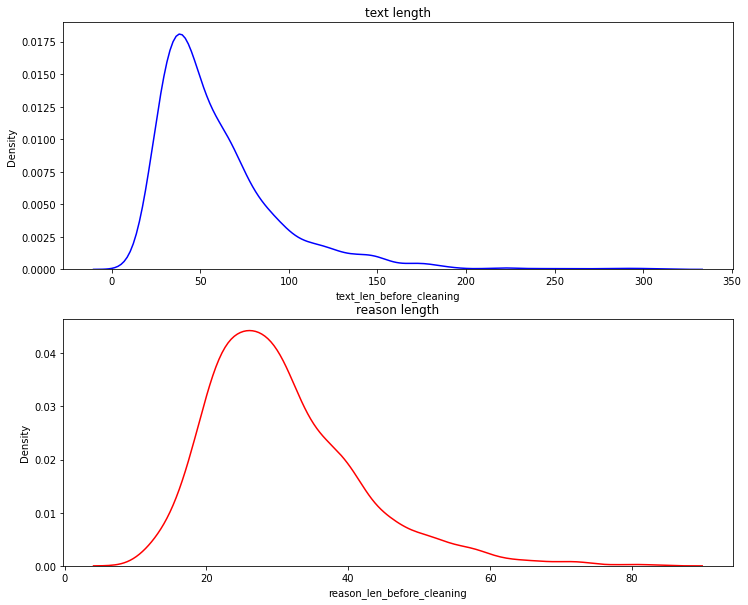

In [ ]:
######### Training Data ################
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
sns.kdeplot(x=train['text_len_before_cleaning'],color='blue')
plt.title('text length')

plt.subplot(2,1,2)
sns.kdeplot(x=train['reason_len_before_cleaning'],color='red')
plt.title('reason length')



Text(0.5, 1.0, 'reason length')

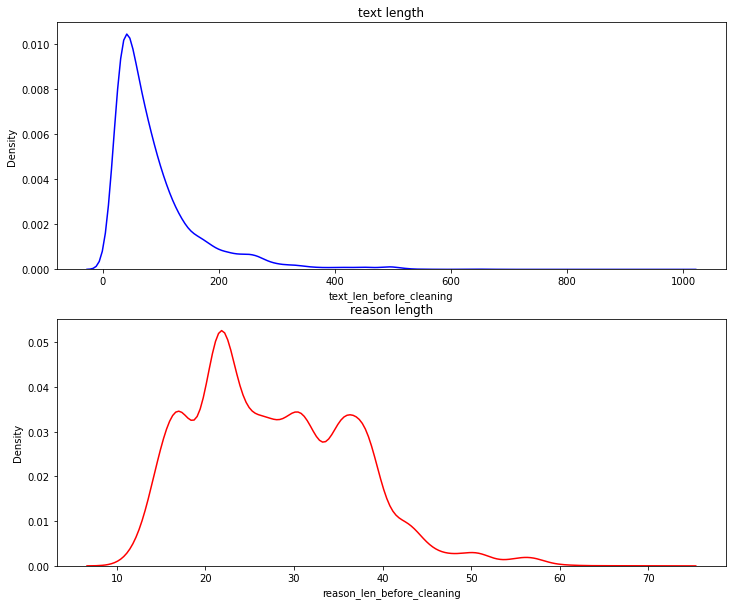

In [ ]:
######### Eval Data ################
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
sns.kdeplot(x=eval['text_len_before_cleaning'],color='blue')
plt.title('text length')

plt.subplot(2,1,2)
sns.kdeplot(x=eval['reason_len_before_cleaning'],color='red')
plt.title('reason length')


Text(0.5, 1.0, 'reason length')

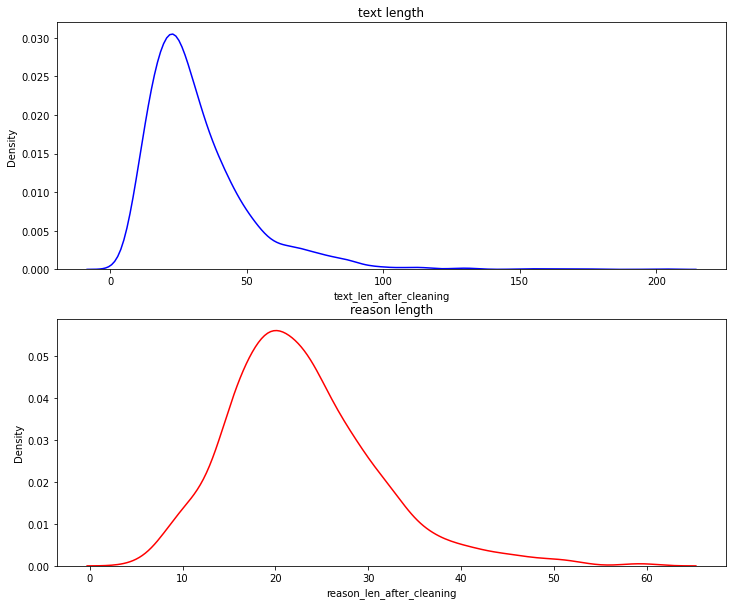

In [ ]:
######### Training Data ################
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
sns.kdeplot(x=train['text_len_after_cleaning'],color='blue')
plt.title('text length')

plt.subplot(2,1,2)
sns.kdeplot(x=train['reason_len_after_cleaning'],color='red')
plt.title('reason length')

Text(0.5, 1.0, 'reason length')

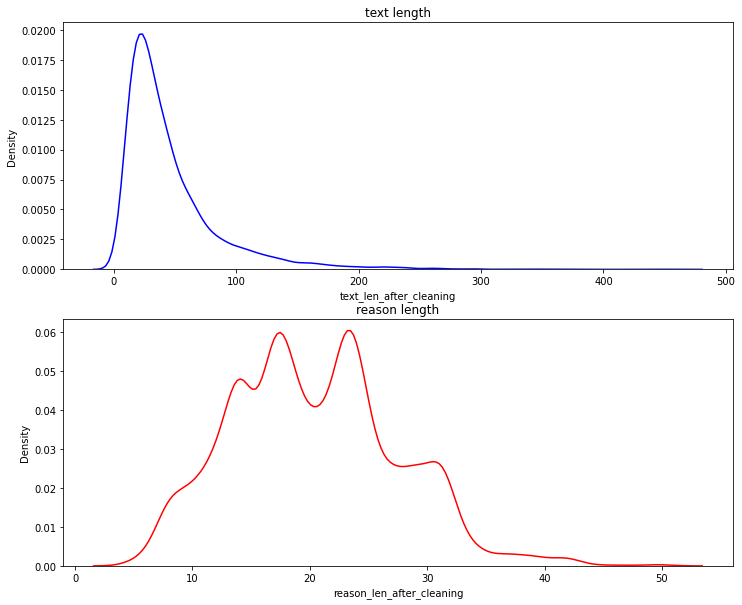

In [ ]:
######### Eval Data ################
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
sns.kdeplot(x=eval['text_len_after_cleaning'],color='blue')
plt.title('text length')

plt.subplot(2,1,2)
sns.kdeplot(x=eval['reason_len_after_cleaning'],color='red')
plt.title('reason length')

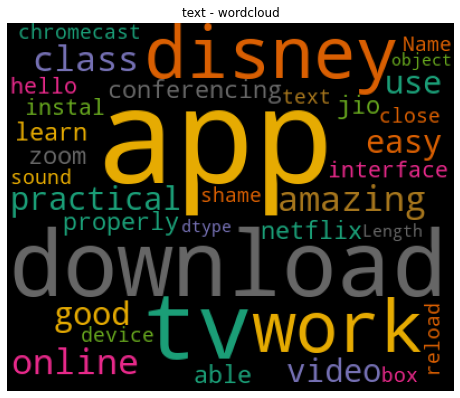

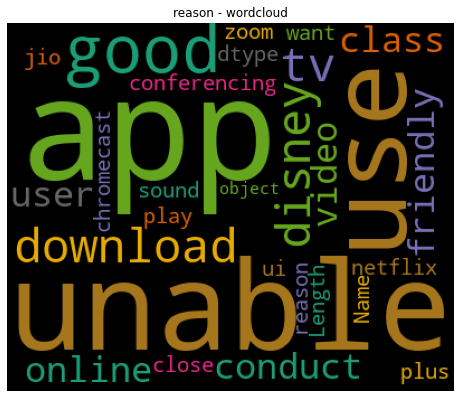

In [ ]:
######### Training Data ################
wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(str(train.text))
plt.figure(figsize=(8,8))
plt.imshow(wc)
plt.axis("off")
plt.title('text - wordcloud')
plt.show()


wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(str(train.reason))
plt.figure(figsize=(8,8))
plt.imshow(wc)
plt.axis("off")
plt.title('reason - wordcloud')
plt.show()
  

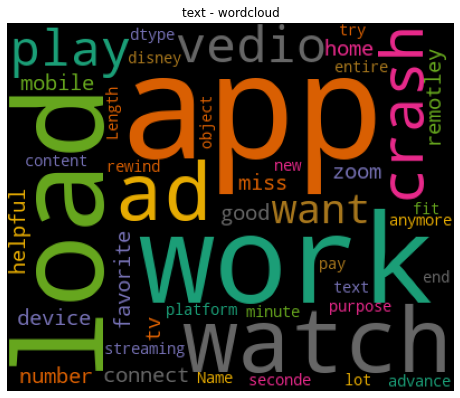

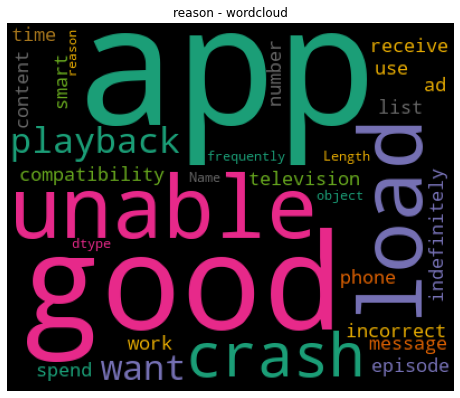

In [ ]:
######### Eval Data ################
wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(str(eval.text))
plt.figure(figsize=(8,8))
plt.imshow(wc)
plt.axis("off")
plt.title('text - wordcloud')
plt.show()


wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(str(eval.reason))
plt.figure(figsize=(8,8))
plt.imshow(wc)
plt.axis("off")
plt.title('reason - wordcloud')
plt.show()
  

Text(0.5, 1.0, 'Eval Similarity')

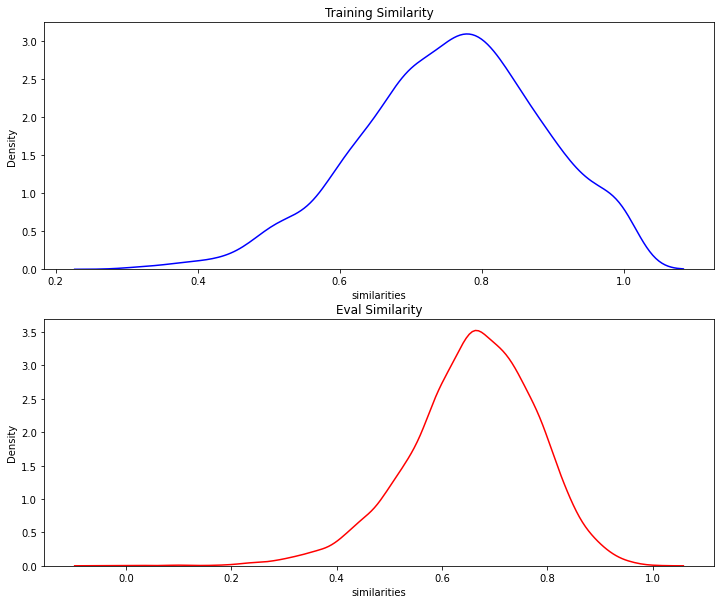

In [ ]:
######### Training Similarity ################
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
sns.kdeplot(x=train['similarities'],color='blue')
plt.title('Training Similarity')

######### Eval Similarity ################
plt.subplot(2,1,2)
sns.kdeplot(x=eval['similarities'],color='red')
plt.title('Eval Similarity')

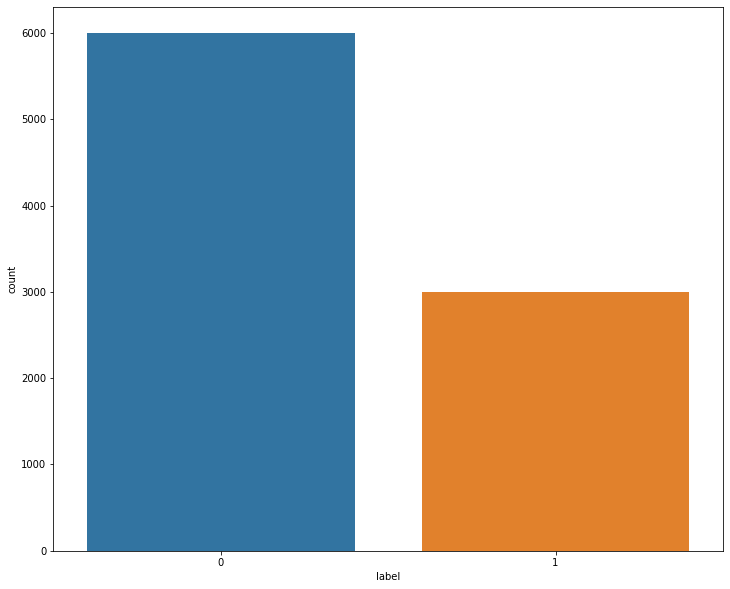

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(data=eval,x='label')

In [ ]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [ ]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
text_unigrams = get_top_n_words(train['text'],20)
reason_unigrams = get_top_n_words(train['reason'],20)

In [ ]:
df1 = pd.DataFrame(text_unigrams, columns = ['text' , 'count'])
df2 = pd.DataFrame(reason_unigrams, columns = ['reason' , 'count'])

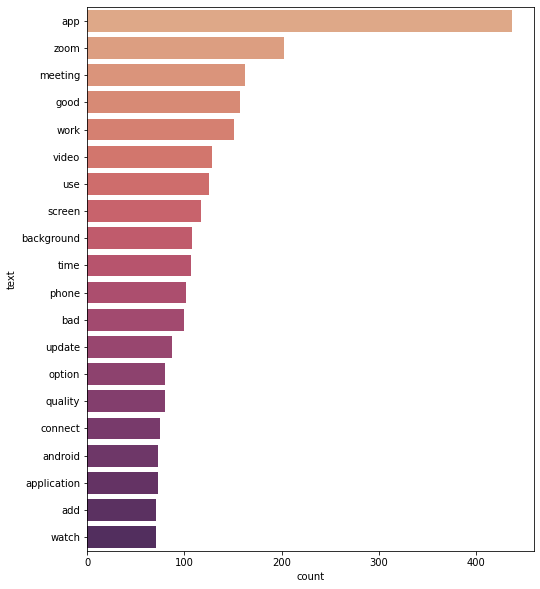

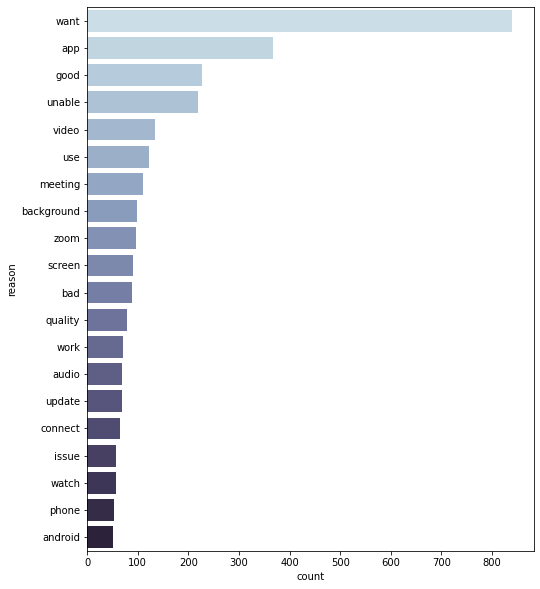

In [ ]:
plt.figure(figsize=(8,10))
sns.barplot(y='text',x='count',data=df1,palette='flare')

plt.figure(figsize=(8,10))
sns.barplot(y='reason',x='count',data=df2,palette='ch:s=.25,rot=-.25')

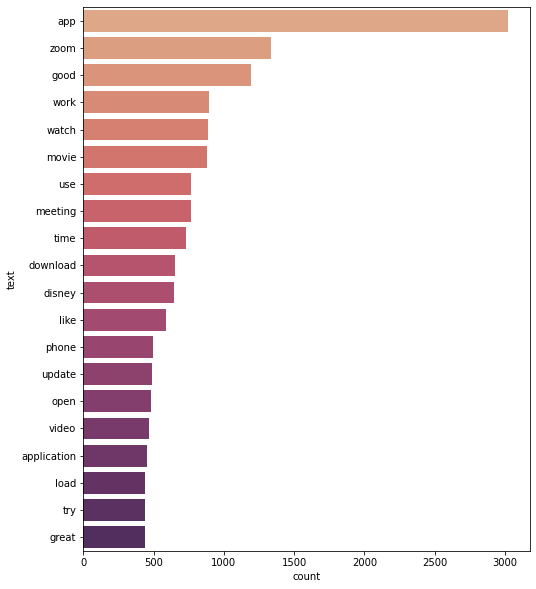

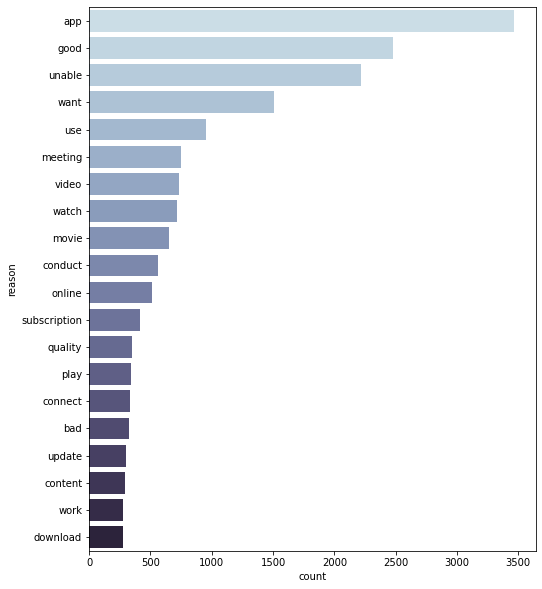

In [ ]:
eval_text_unigrams = get_top_n_words(eval['text'],20)
eval_reason_unigrams = get_top_n_words(eval['reason'],20)


df3 = pd.DataFrame(eval_text_unigrams, columns = ['text' , 'count'])
df4 = pd.DataFrame(eval_reason_unigrams, columns = ['reason' , 'count'])

plt.figure(figsize=(8,10))
sns.barplot(y='text',x='count',data=df3,palette='flare')

plt.figure(figsize=(8,10))
sns.barplot(y='reason',x='count',data=df4,palette='ch:s=.25,rot=-.25')

In [ ]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

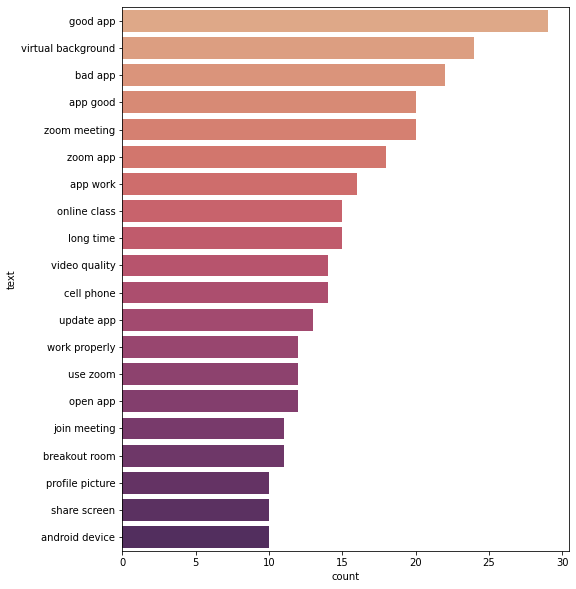

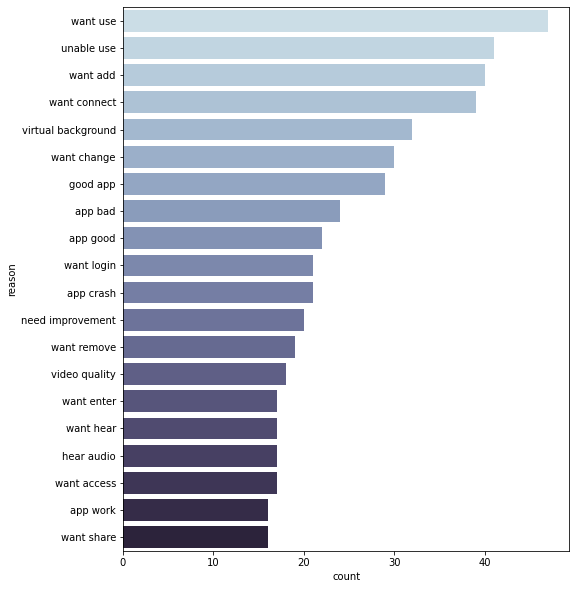

In [ ]:
text_bigrams = get_top_n_gram(train['text'],(2,2),20)
reason_bigrams = get_top_n_gram(train['reason'],(2,2),20)

df1 = pd.DataFrame(text_bigrams, columns = ['text' , 'count'])
df2 = pd.DataFrame(reason_bigrams, columns = ['reason' , 'count'])

plt.figure(figsize=(8,10))
sns.barplot(y='text',x='count',data=df1,palette='flare')

plt.figure(figsize=(8,10))
sns.barplot(y='reason',x='count',data=df2,palette='ch:s=.25,rot=-.25')

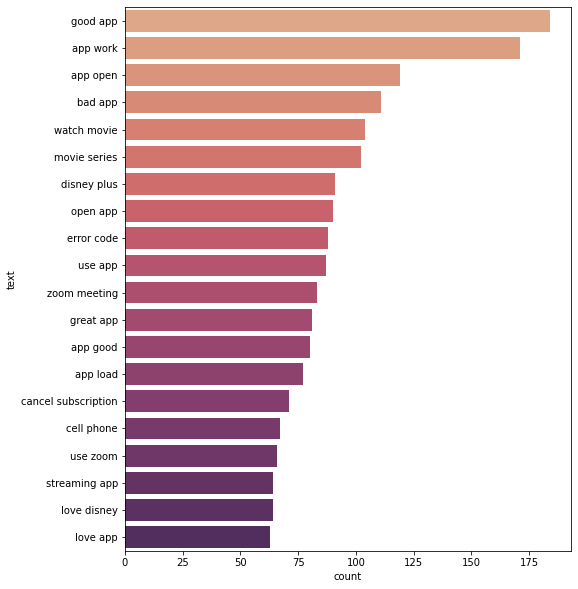

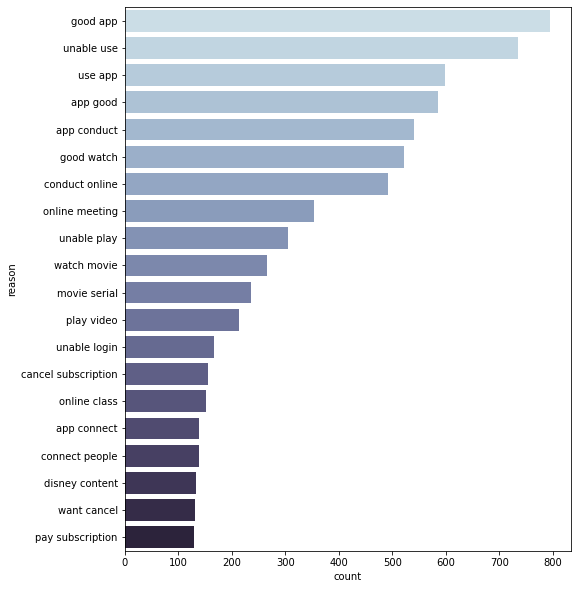

In [ ]:
eval_text_bigrams = get_top_n_gram(eval['text'],(2,2),20)
eval_reason_bigrams = get_top_n_gram(eval['reason'],(2,2),20)


df3 = pd.DataFrame(eval_text_bigrams, columns = ['text' , 'count'])
df4 = pd.DataFrame(eval_reason_bigrams, columns = ['reason' , 'count'])

plt.figure(figsize=(8,10))
sns.barplot(y='text',x='count',data=df3,palette='flare')

plt.figure(figsize=(8,10))
sns.barplot(y='reason',x='count',data=df4,palette='ch:s=.25,rot=-.25')

In [ ]:
text_trigrams = get_top_n_gram(train['text'],(3,3),20)
reason_trigrams = get_top_n_gram(train['reason'],(2,2),20)

df1 = pd.DataFrame(text_trigrams, columns = ['text' , 'count'])
df2 = pd.DataFrame(reason_trigrams, columns = ['reason' , 'count'])

plt.figure(figsize=(8,10))
sns.barplot(y='text',x='count',data=df1,palette='flare')

plt.figure(figsize=(8,10))
sns.barplot(y='reason',x='count',data=df2,palette='ch:s=.25,rot=-.25')

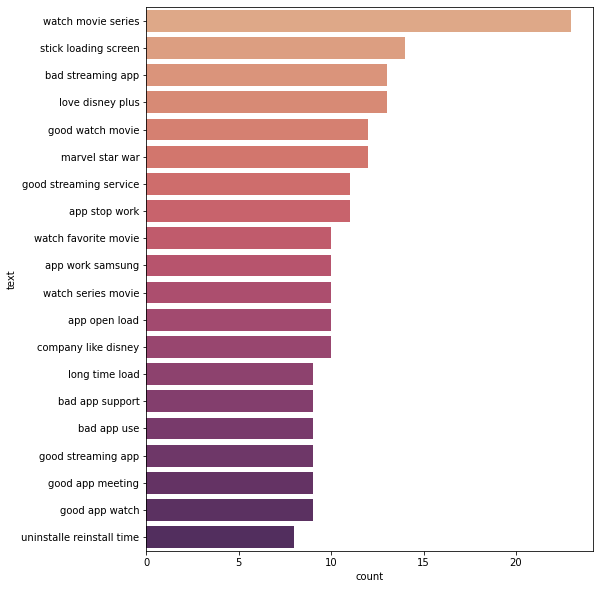

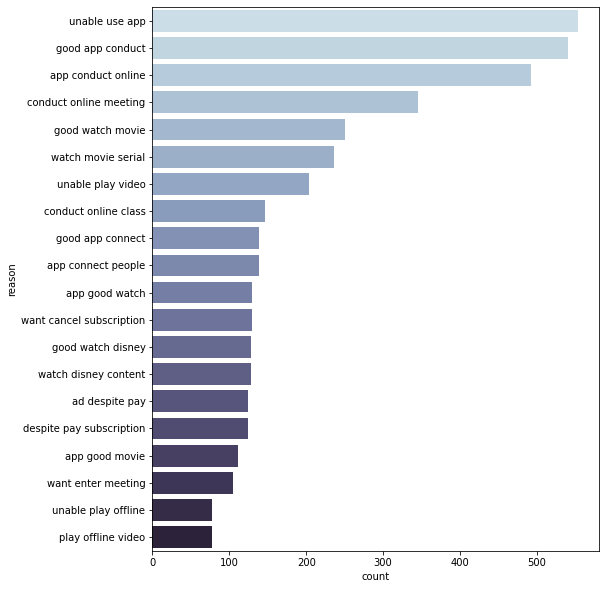

In [ ]:
eval_text_trigrams = get_top_n_gram(eval['text'],(3,3),20)
eval_reason_trigrams = get_top_n_gram(eval['reason'],(3,3),20)


df3 = pd.DataFrame(eval_text_trigrams, columns = ['text' , 'count'])
df4 = pd.DataFrame(eval_reason_trigrams, columns = ['reason' , 'count'])

plt.figure(figsize=(8,10))
sns.barplot(y='text',x='count',data=df3,palette='flare')

plt.figure(figsize=(8,10))
sns.barplot(y='reason',x='count',data=df4,palette='ch:s=.25,rot=-.25')

# Training and Evaluation

In [ ]:
train = train.drop(columns=['text_len_before_cleaning','reason_len_before_cleaning'],axis=1)

eval = eval.drop(columns=['text_len_before_cleaning','reason_len_before_cleaning'],axis=1)

In [ ]:
X_train = train.drop('label',axis=1)
y_train = train.label

X_eval = eval.drop('label',axis=1)
y_eval = eval.label

In [ ]:
X_train = X_train.drop(columns=['text','reason'],axis=1)

In [ ]:
X_eval = X_eval.drop(columns=['text','reason'],axis=1)

In [ ]:
X_train.head()

,similarities,text_len_after_cleaning,reason_len_after_cleaning,text_vec,reason_vec
0,0.773945,24,29,"[-0.1290249294704861, 0.07010565863715278, 0.0...","[-0.1470820109049479, 0.09561920166015625, 0.0..."
1,0.499896,18,17,"[-0.17535400390625, 0.11171177455357142, 0.000...","[-0.13930257161458334, 0.11983235677083333, 0...."
2,0.801849,27,23,"[-0.13333892822265625, 0.0756988525390625, 0.0...","[-0.14026711203835227, 0.07121693004261363, 0...."
3,0.748644,17,24,"[-0.105377197265625, 0.10087367466517858, -0.0...","[-0.1075182462993421, 0.09835012335526316, -0...."
4,0.774559,17,17,"[-0.0921771709735577, 0.12519719050480768, -0....","[-0.11414513221153846, 0.10946890024038461, -0..."


In [ ]:
X_eval.head()

,similarities,text_len_after_cleaning,reason_len_after_cleaning,text_vec,reason_vec
0,0.601925,20,18,"[-0.11913248697916666, 0.12357584635416667, 0....","[-0.13627741887019232, 0.09775015024038461, 0...."
1,0.656717,22,35,"[-0.11965139288651316, 0.07869680304276316, -0...","[-0.17364501953125, 0.10035400390625, -0.03670..."
2,0.657667,26,13,"[-0.14615376790364584, 0.13763427734375, -0.01...","[-0.14357688210227273, 0.07375821200284091, 0...."
3,0.717309,23,38,"[-0.1606997535342262, 0.09434872581845238, 0.0...","[-0.16045604032628677, 0.10437191233915441, 0...."
4,0.516351,12,15,"[-0.12646484375, 0.10091552734375, 0.005041503...","[-0.15114484514508927, 0.11383492606026786, -0..."


In [ ]:
X = X_train['text_vec'].to_list()
y = y_train.to_list()

In [ ]:
e_X = X_eval['text_vec'].to_list()
e_y = y_eval.to_list()

In [ ]:
one_svm = OneClassSVM(gamma='auto',kernel='rbf').fit(X)

In [ ]:
prediction = one_svm.predict(e_X)

In [ ]:
prediction

array([-1, -1,  1, ..., -1,  1,  1])

In [ ]:
prediction = [1 if i==-1 else 0 for i in prediction]

In [ ]:
prediction = np.array(prediction)
print(np.unique(prediction))

[0 1]


In [ ]:
print(classification_report(prediction,y_eval))

              precision    recall  f1-score   support

           0       0.58      0.67      0.62      5186
           1       0.43      0.33      0.37      3814

    accuracy                           0.53      9000
   macro avg       0.50      0.50      0.50      9000
weighted avg       0.51      0.53      0.52      9000



In [ ]:
print(confusion_matrix(prediction,y_eval))

[[3461 1725]
 [2538 1276]]


In [ ]:
tfv = TfidfVectorizer()
cv = CountVectorizer()

In [ ]:
train.head()

,text,reason,label,similarities,text_len_after_cleaning,reason_len_after_cleaning,text_vec,reason_vec
0,amazing app online class,good app conduct online class,1,0.773945,24,29,"[-0.1290249294704861, 0.07010565863715278, 0.0...","[-0.1470820109049479, 0.09561920166015625, 0.0..."
1,practical easy use,app user friendly,1,0.499896,18,17,"[-0.17535400390625, 0.11171177455357142, 0.000...","[-0.13930257161458334, 0.11983235677083333, 0...."
2,app good video conferencing,good video conferencing,1,0.801849,27,23,"[-0.13333892822265625, 0.0756988525390625, 0.0...","[-0.14026711203835227, 0.07121693004261363, 0...."
3,download zoom app,unable download zoom app,1,0.748644,17,24,"[-0.105377197265625, 0.10087367466517858, -0.0...","[-0.1075182462993421, 0.09835012335526316, -0...."
4,able download app,want download app,1,0.774559,17,17,"[-0.0921771709735577, 0.12519719050480768, -0....","[-0.11414513221153846, 0.10946890024038461, -0..."


In [ ]:
text = tfv.fit_transform(train['text'])
eval_text = tfv.transform(eval['text'])

In [ ]:
reason = tfv.fit_transform(train['reason'])
eval_reason = tfv.transform(eval['reason'])

In [ ]:
encoded_text = pd.DataFrame(text.toarray())

encoded_eval_text = pd.DataFrame(eval_text.toarray())
encoded_eval_text.head()

,0,1,2,3,4,5,6,7,8,9,...,1675,1676,1677,1678,1679,1680,1681,1682,1683,1684
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.319987,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
new_train = pd.concat([train, encoded_text], axis=1)
new_train.head()

,text,reason,label,similarities,text_len_after_cleaning,reason_len_after_cleaning,text_vec,reason_vec,0,1,...,1675,1676,1677,1678,1679,1680,1681,1682,1683,1684
0,amazing app online class,good app conduct online class,1,0.773945,24,29,"[-0.1290249294704861, 0.07010565863715278, 0.0...","[-0.1470820109049479, 0.09561920166015625, 0.0...",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,practical easy use,app user friendly,1,0.499896,18,17,"[-0.17535400390625, 0.11171177455357142, 0.000...","[-0.13930257161458334, 0.11983235677083333, 0....",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,app good video conferencing,good video conferencing,1,0.801849,27,23,"[-0.13333892822265625, 0.0756988525390625, 0.0...","[-0.14026711203835227, 0.07121693004261363, 0....",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,download zoom app,unable download zoom app,1,0.748644,17,24,"[-0.105377197265625, 0.10087367466517858, -0.0...","[-0.1075182462993421, 0.09835012335526316, -0....",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.539812,0.0,0.0
4,able download app,want download app,1,0.774559,17,17,"[-0.0921771709735577, 0.12519719050480768, -0....","[-0.11414513221153846, 0.10946890024038461, -0...",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
new_eval = pd.concat([eval, encoded_eval_text], axis=1)
new_eval.head()

,text,reason,label,similarities,text_len_after_cleaning,reason_len_after_cleaning,text_vec,reason_vec,0,1,...,1675,1676,1677,1678,1679,1680,1681,1682,1683,1684
0,app crash play vedio,app crash playback,1,0.601925,20,18,"[-0.11913248697916666, 0.12357584635416667, 0....","[-0.13627741887019232, 0.09775015024038461, 0....",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,want connect tv device,want compatibility smart television,0,0.656717,22,35,"[-0.11965139288651316, 0.07869680304276316, -0...","[-0.17364501953125, 0.10035400390625, -0.03670...",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,helpful home work remotley,good app work,0,0.657667,26,13,"[-0.14615376790364584, 0.13763427734375, -0.01...","[-0.14357688210227273, 0.07375821200284091, 0....",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,zoom miss mobile number,receive incorrect phone number message,0,0.717309,23,38,"[-0.1606997535342262, 0.09434872581845238, 0.0...","[-0.16045604032628677, 0.10437191233915441, 0....",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.319987,0.0,0.0
4,favorite app,good spend time,0,0.516351,12,15,"[-0.12646484375, 0.10091552734375, 0.005041503...","[-0.15114484514508927, 0.11383492606026786, -0...",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
X_new_train = new_train.drop(columns=['text','reason','text_vec','reason_vec','label'],axis=1)
y_new_train = new_train.label

X_new_eval = new_eval.drop(columns=['text','reason','text_vec','reason_vec','label'],axis=1)
y_new_eval = new_eval.label

In [ ]:
X_new_train.head()

,similarities,text_len_after_cleaning,reason_len_after_cleaning,0,1,2,3,4,5,6,...,1675,1676,1677,1678,1679,1680,1681,1682,1683,1684
0,0.773945,24,29,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.499896,18,17,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.801849,27,23,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.748644,17,24,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.539812,0.0,0.0
4,0.774559,17,17,0.0,0.0,0.656686,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
X_new_eval.head()

,similarities,text_len_after_cleaning,reason_len_after_cleaning,0,1,2,3,4,5,6,...,1675,1676,1677,1678,1679,1680,1681,1682,1683,1684
0,0.601925,20,18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.656717,22,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.657667,26,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.717309,23,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.319987,0.0,0.0
4,0.516351,12,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
one_svm_2 = OneClassSVM(gamma='auto',kernel='rbf').fit(X_new_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [ ]:
pred = one_svm_2.predict(X_new_eval)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [ ]:
pred = [1 if i==-1 else 0 for i in pred]
pred = np.array(pred)
print(np.unique(pred))

[0 1]


In [ ]:
print(classification_report(pred,y_new_eval))

              precision    recall  f1-score   support

           0       0.34      0.65      0.44      3118
           1       0.63      0.32      0.43      5882

    accuracy                           0.43      9000
   macro avg       0.48      0.48      0.43      9000
weighted avg       0.53      0.43      0.43      9000



In [ ]:
print(confusion_matrix(pred,y_new_eval))

[[2014 1104]
 [3985 1897]]


In [ ]:
#train = train.drop(['text_len_after_cleaning','reason_len_after_cleaning'],axis=1)

In [ ]:
#eval = eval.drop(['text_len_after_cleaning','reason_len_after_cleaning'],axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          9000 non-null   object 
 1   reason        9000 non-null   object 
 2   label         9000 non-null   int64  
 3   similarities  9000 non-null   float64
 4   text_vec      9000 non-null   object 
 5   reason_vec    9000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 422.0+ KB


In [ ]:
y_eval.value_counts()

0    5999
1    3001
Name: label, dtype: int64

In [ ]:
train.head()

,text,reason,label,similarities,text_vec,reason_vec
0,amazing app online class,good app conduct online class,1,0.773945,"[-0.1290249294704861, 0.07010565863715278, 0.0...","[-0.1470820109049479, 0.09561920166015625, 0.0..."
1,practical easy use,app user friendly,1,0.499896,"[-0.17535400390625, 0.11171177455357142, 0.000...","[-0.13930257161458334, 0.11983235677083333, 0...."
2,app good video conferencing,good video conferencing,1,0.801849,"[-0.13333892822265625, 0.0756988525390625, 0.0...","[-0.14026711203835227, 0.07121693004261363, 0...."
3,download zoom app,unable download zoom app,1,0.748644,"[-0.105377197265625, 0.10087367466517858, -0.0...","[-0.1075182462993421, 0.09835012335526316, -0...."
4,able download app,want download app,1,0.774559,"[-0.0921771709735577, 0.12519719050480768, -0....","[-0.11414513221153846, 0.10946890024038461, -0..."


In [ ]:
len(train.text_vec[0])

300